# **Fake news classifier**

In [112]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [113]:
# Retrieve the data
df = pd.read_csv('rumor_detection_acl2017/twitter15/source_tweets.txt', sep=r'\t', engine='python')
df = df.fillna(' ')
df.head()
print(df.count())

label = pd.read_csv('rumor_detection_acl2017/twitter15/label.txt', sep=r':', engine='python')
label = label.fillna(' ')
label.head()
label.count()

df = df.merge(label)
df = df[df.label != 'unverified']
df = df[df.label != 'non-rumor']
df.label = pd.Categorical(df.label)
df['code'] = df.label.cat.codes

df['label'] = df.label.astype('category').cat.codes
print(df.count())
df.head()


ID      1490
text    1490
dtype: int64
ID       742
text     742
label    742
code     742
dtype: int64


,ID,text,label,code
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,1,1
7,514106273852174337,just in: missing afghan soldiers found trying ...,1,1
9,495366618818830336,#riphulkhogan my heart is ripping like your sh...,0,0
10,532206910796468224,a chick-fil-a manager allegedly banned this hi...,0,0
11,560187970389819392,islamic tribunal using sharia law in texas has...,0,0


In [114]:
# test data
df2 = pd.read_csv('rumor_detection_acl2017/twitter16/source_tweets.txt', sep=r'\t', engine='python')
df2 = df2.fillna(' ')
df2.head()
print(df2.count())

label2 = pd.read_csv('rumor_detection_acl2017/twitter16/label.txt', sep=r':', engine='python')
label2 = label2.fillna(' ')
label2.head()
label2.count()

df2 = df2.merge(label2)
df2 = df2[df2.label != 'unverified']
df2 = df2[df2.label != 'non-rumor']
df2.label = pd.Categorical(df2.label)
df2['code'] = df2.label.cat.codes

#df['label'] = df.label.astype('category').cat.codes
#df = df.append(df2)
print(df.count())
df.head()

ID      818
text    818
dtype: int64
ID       742
text     742
label    742
code     742
dtype: int64


,ID,text,label,code
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,1,1
7,514106273852174337,just in: missing afghan soldiers found trying ...,1,1
9,495366618818830336,#riphulkhogan my heart is ripping like your sh...,0,0
10,532206910796468224,a chick-fil-a manager allegedly banned this hi...,0,0
11,560187970389819392,islamic tribunal using sharia law in texas has...,0,0


In [115]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['text'])
padded = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')
print(padded)

2729
[[ 135  236  108 ...    0    0    0]
 [  74    4   82 ...    0    0    0]
 [ 805  137  466 ...    0    0    0]
 ...
 [1251 1121 1247 ...    0    0    0]
 [ 172 2726   58 ...    0    0    0]
 [ 185 2729    1 ...    0    0    0]]


In [116]:
from sklearn.model_selection import train_test_split
labels = df['code']
train_data, test_data, train_labels, test_labels = train_test_split(padded, labels, test_size=0.20, random_state=42)
#train_labels = to_categorical(train_labels, 4)
#test_labels = to_categorical(test_labels, 4)
print(train_labels)


963    1
587    0
712    0
369    0
290    0
      ..
158    1
228    0
546    1
872    1
219    0
Name: code, Length: 593, dtype: int8


In [ ]:
# Import tensor representations for words

#!wget --no-check-certificate \
   # https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
   # -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('glove.twitter.27B.50d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 50));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Embedding(vocab_size+1, 50, weights=[embeddings_matrix], trainable=False))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.LSTM(10, return_sequences=True))
model.add(layers.LSTM(10))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128))
#model.add(layers.Dense(1, activation='sigmoid'))

In [86]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(train_data, train_labels, epochs=10, batch_size=50, validation_data=(test_data, test_labels))

print("Training Complete")

# saving the model
model_path = 'keras_fakenews11.h5'
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          182500    
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          8032      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 10)          1720      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0

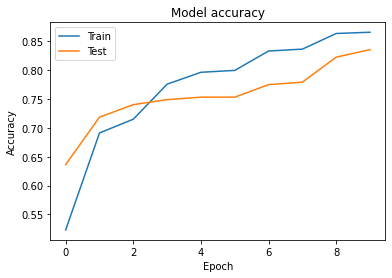

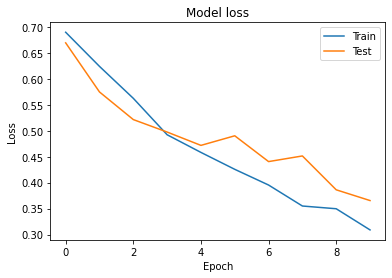

In [87]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [88]:
fakenews_model = tf.keras.models.load_model('keras_fakenews11.h5')
loss_and_metrics = fakenews_model.evaluate(test_data, test_labels, verbose=2)
print(fakenews_model.get_config())

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

8/8 - 0s - loss: 0.3655 - accuracy: 0.8355
{'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'embedding_input'}}, {'class_name': 'Embedding', 'config': {'name': 'embedding', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 3650, 'output_dim': 50, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}}, {'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}}, {'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (5,), 'strides': (1,), 'padding': 'valid', 'data_format': 'channels_la

<AxesSubplot:>

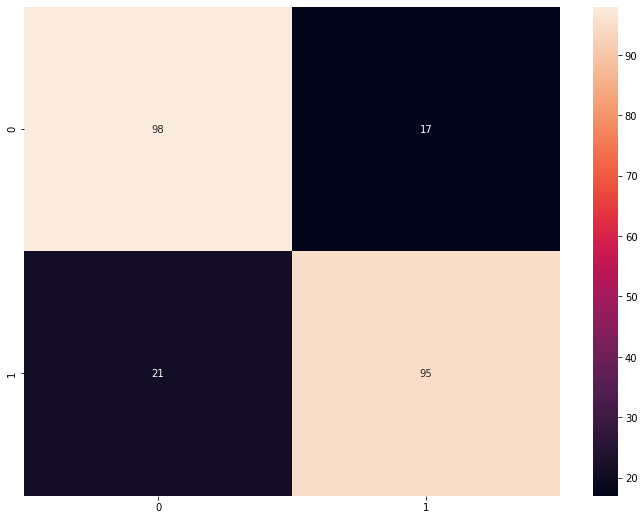

In [89]:
# load the model and create predictions on the test set
fakenews_model = tf.keras.models.load_model(model_path)
predicted_classes = fakenews_model.predict_classes(test_data)
#predicted_classes = predicted_classes.reshape(-1,1)
#rounded_labels=np.argmax(test_labels, axis=1)
#rounded_predict=np.argmax(predicted_classes, axis=1)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = test_labels, y_pred = predicted_classes)
import seaborn as sns
plt.figure(figsize=(12, 9))

sns.heatmap(cm, annot=True, fmt='d')


In [90]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(test_labels, predicted_classes, average='micro')

(0.8354978354978355, 0.8354978354978355, 0.8354978354978355, None)

In [91]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_classes)

0.8354978354978355

In [92]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_classes)

0.8482142857142857

In [93]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_classes)

0.8333333333333334

In [94]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_classes)

0.8189655172413793

In [95]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_classes)

0.8482142857142857

In [103]:
#data_size: the total number of data you want to put in the model( for example: twitter15 is 742)
#retweet_user_size: the length of retweet propagation you want to utilize( in the paper we use 40 retweet users)
data_size=742
retweet_user_size=40

##read the Data 
import numpy as np
import os
path="rumor_detection_acl2017/twitter15/tree/"
files= os.listdir(path)
a=[]
nodes2 = []
weights2 = []
k=[]
for file in files:
    f = open(path + file.format(file))
    results=[]
    nodes = []
    weights = []
    k.append(file)    
    next(f)
    i = 0
    for line in f.readlines():
        if "ROOT" in line:
            i = i + 1
        else:
            line = line.replace("[", "")
            line = line.replace("]", "")
            line = line.replace("'", "")
            line = line.replace("->", ",")
            results.append(list(map(float,line.split(','))))
    for i in range(len(results)):
        weights.append(results[i][5]-results[i][2])
        results[i].pop(1)
        results[i].pop(1)
        results[i].pop(2)
        results[i].pop(2)
        nodes.append(results[i][0])
        nodes.append(results[i][1])
    results=np.array(results)
    results=results.tolist()
    a.append(results)  
    nodes2.append(nodes)
    weights2.append(weights)

##let all the rewteet user size of news be the same
import random
from sklearn import preprocessing
data_all=[]
for i in range(0,data_size):
    if len(a[i])>=retweet_user_size:
        k=a[i][0:retweet_user_size]
        data_all.append(k)
    else:
        a[i]=np.asarray(a[i])
        q=a[i][np.random.choice(a[i].shape[0],retweet_user_size,replace=True),:]
        q=q.tolist()
        a[i]=a[i].tolist()
        k=a[i].extend(q)
        k=a[i][0:retweet_user_size]
        
        data_all.append(k)


In [104]:
for i in range(len(nodes2)):
    nodes2[i] = list(set(nodes2[i])) 

In [105]:
import networkx as nx
matrices = []
for i in range(len(data_all)):
    first = np.array(data_all[i])
    first2 = data_all[i]
    weight = weights2[i]
    for j in range(len(first2)):
        first2[j] = tuple(first2[j])
    G = nx.DiGraph()
    G.add_edges_from(first, weights=1)
    G.add_nodes_from(nodes2[i])
    zipbObj = zip(first2, weight)
    dict_weights = dict(zipbObj)
    nx.set_edge_attributes(G, values = dict_weights, name = 'weight')
    G.edges(data = True)     
    A_hat = nx.adjacency_matrix(G)
    matrices.append(A_hat.toarray())
matrices[0]

array([[0.  , 3.08, 3.08, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [106]:
from padding2 import padd
for i in range(742):
    matrices[i] = matrices[i][~(matrices[i]==0).all(1)]

max2 = len(matrices[0])
max3 = matrices[0].shape[1]
for i in range(len(matrices)):
    if (len(matrices[i]) > max2):
        max2 = len(matrices[i])
    if(matrices[i].shape[1] > max3):
        max3 = matrices[i].shape[1]
print(max2)
print(max3)

for i in range(742):
    matrices[i] = np.pad(matrices[i], ((0,(max2 - len(matrices[i]))),(0,(max3 - matrices[i].shape[1]))), 'constant')
print(matrices[2].shape)

15
2971
(15, 2971)


In [107]:
matrice2 = np.array(matrices)
print(matrice2[0])

[[0.   3.08 3.08 ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [108]:
X_train, X_test, train_data, test_data, y_train, y_test = train_test_split(matrice2, padded, labels, test_size=0.2, random_state=42)
X_train2 = X_train.reshape((X_train.shape[0], 15, 2971, 1))
X_test2 = X_test.reshape((X_test.shape[0], 15, 2971, 1))

# one hot encode target values
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
#y_train = np.asarray(y_train).reshape((-1,1))
#y_test = np.asarray(y_test).reshape((-1,1))

#X_train = X_train.reshape(X_train.shape[0], 15, 2971)
#X_test = X_test.reshape(X_test.shape[0], 15, 2971)

ValueError: Found input variables with inconsistent numbers of samples: [742, 1154, 1154]

In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(15, 2971, 1)))
model2.add(layers.MaxPooling2D(4, 4))


model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(256))
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(128))

#model2.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model2.compile(loss='binary_crossentropy',
optimizer='adam',
metrics='accuracy')

history = model2.fit(X_train2, y_train, epochs=4, 
                    validation_data=(X_test2, y_test))

model_path = 'keras_cnnmodel2.h5'
model2.save(model_path)
print('Saved trained model at %s ' % model_path)

Epoch 1/4
19/19 [==============================] - 23s 1s/step - loss: 15.7397 - accuracy: 0.4992 - val_loss: 2.1045 - val_accuracy: 0.4765
Epoch 2/4
19/19 [==============================] - 22s 1s/step - loss: 6.0576 - accuracy: 0.5700 - val_loss: 1.0458 - val_accuracy: 0.5034
Epoch 3/4
19/19 [==============================] - 24s 1s/step - loss: 1.7652 - accuracy: 0.5531 - val_loss: 1.4934 - val_accuracy: 0.5101
Epoch 4/4
19/19 [==============================] - 25s 1s/step - loss: 0.8089 - accuracy: 0.5649 - val_loss: 1.7938 - val_accuracy: 0.4564
Saved trained model at keras_cnnmodel2.h5 


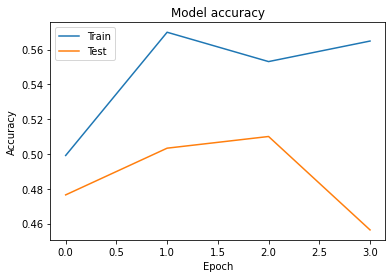

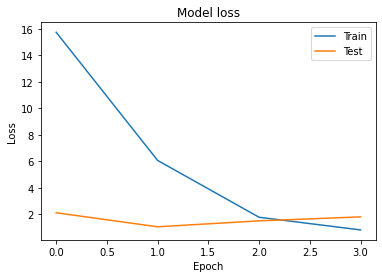

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

<AxesSubplot:>

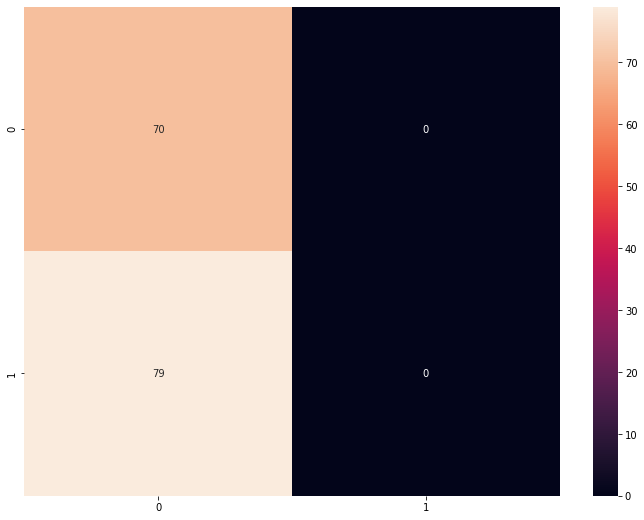

In [38]:
fakenews_model2 = tf.keras.models.load_model(model_path)
predicted_classes = fakenews_model2.predict(X_test2)
classes = np.argmax(predicted_classes, axis=1)


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = classes)
import seaborn as sns
plt.figure(figsize=(12, 9))

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Flatten, Input, concatenate
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.models import Model
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([model.output, model2.output])

# The final fully-connected layer head will have two dense layers (one relu and one sigmoid)

x = Dense(64, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model1 = Model(inputs=[model.input, model2.input], outputs=x)

# Compile the model 
opt = Adam()
model1.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# Train the model
model1_history = model1.fit(
  [train_data, X_train], 
  y_train, 
  validation_data=([test_data, X_test], y_test), 
  epochs=6, 
  batch_size=20)

model_path = 'keras_fullmodel2.h5'
model1.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
plt.plot(model1_history.history['acc'])
plt.plot(model1_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(model1_history.history['loss'])
plt.plot(model1_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
model1.summary()

In [ ]:
fakenews_model = tf.keras.models.load_model(model_path)
predicted_classes = fakenews_model.predict([test_data, X_test])
classes = np.argmax(predicted_classes, axis=1)


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = classes)
import seaborn as sns
plt.figure(figsize=(12, 9))

sns.heatmap(cm, annot=True, fmt='d')